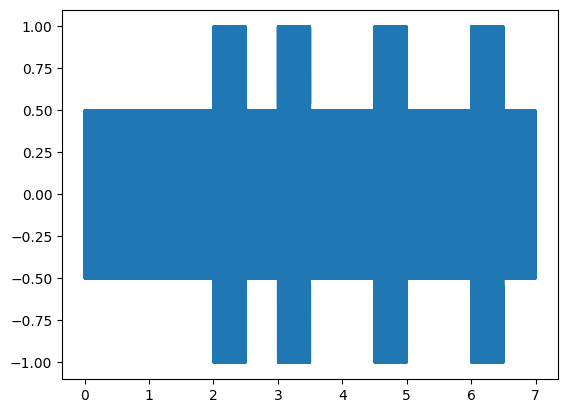

In [2]:
import numpy as np
import scipy
import scipy.signal as sp
import TC_Functions as TC
import matplotlib.pyplot as plt

data = np.random.randint(0, 2, 10)
data = np.r_[np.zeros(4), data]
modulated_am = TC.am_modulate(data, 44e3, 1e3, 500)
scipy.io.wavfile.write('AM.wav', int(44e3), np.array(32760 * modulated_am, dtype=np.int16))
plt.plot(np.arange(len(modulated_am)) / 44e3, modulated_am)
TC.display_audio_signal(modulated_am)

Recording... Press 'q' to stop.


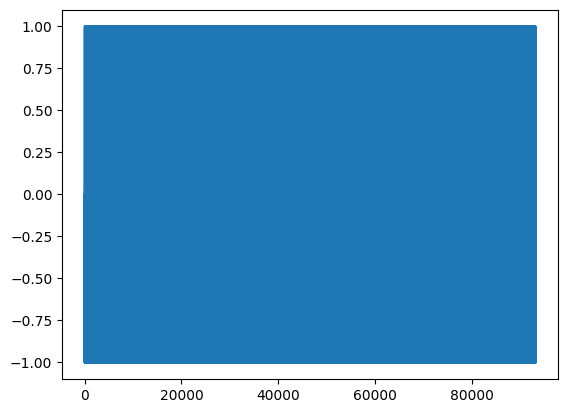

In [4]:
fs, received_signal = TC.record_audio(int(44e3))
scipy.io.wavfile.write('AM_rx.wav', fs, np.array(received_signal, dtype=np.int16))
plt.plot(received_signal)

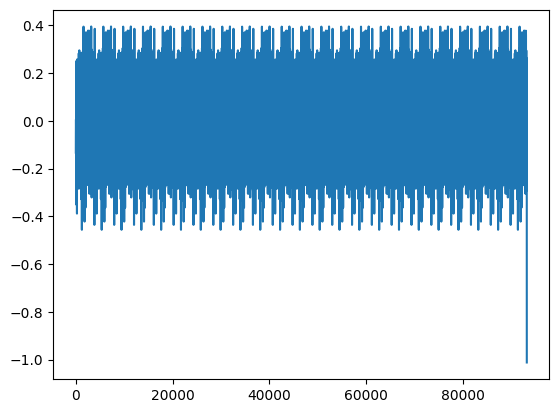

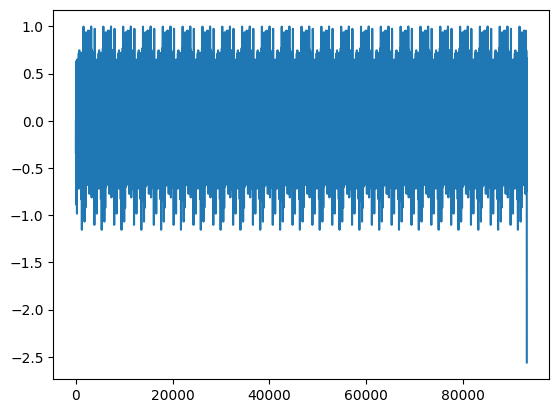

In [5]:
fs_AM_RX, AM_RX = scipy.io.wavfile.read('AM_rx.wav')
# Apply low-pass filter to the demodulated signal directly here
nyq = 0.5 * fs
normal_cutoff = 2*1e3 / nyq
b, a = sp.butter(5, normal_cutoff, btype='low', analog=False)
filter_AM_RX = sp.filtfilt(b, a, AM_RX)

plt.plot(filter_AM_RX)
plt.show()

filter_AM_RX_1 = filter_AM_RX/np.max(filter_AM_RX)
plt.plot(filter_AM_RX_1)
plt.show()